<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/mask-no-mask/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA

import pickle

In [132]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/mask-no-mask/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
  inflating: data/mask/1.jpg         
  inflating: data/mask/10.jpg        
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
  inflating: data/no_mask/1.jpg      
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      


In [146]:
!wget https://github.com/Itseez/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye.xml

--2020-07-09 13:32:31--  https://github.com/Itseez/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml [following]
--2020-07-09 13:32:32--  https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml [following]
--2020-07-09 13:32:32--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.

In [147]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascade_eye.xml')

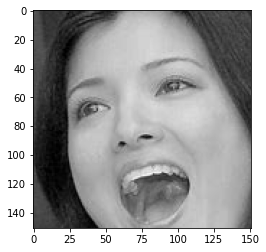

In [148]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [149]:
detect(face_cascade, './data/mask/1.jpg')

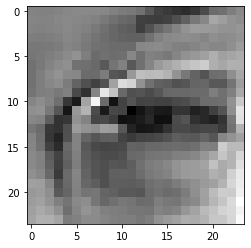

In [150]:
detect(eye_cascade, './data/mask/1.jpg')

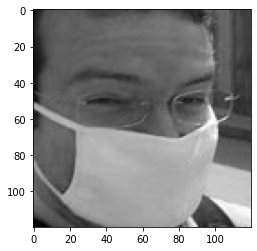

In [161]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

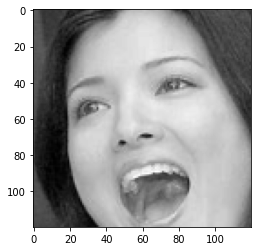

In [162]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

10.jpg


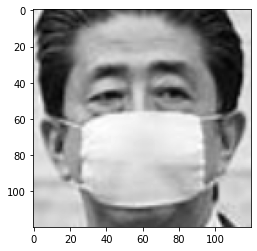

3.jpg


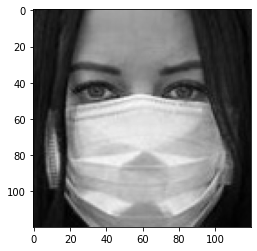

8.jpg


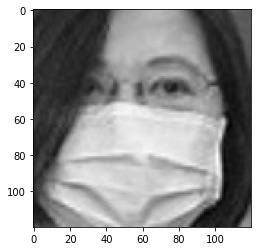

4.jpg


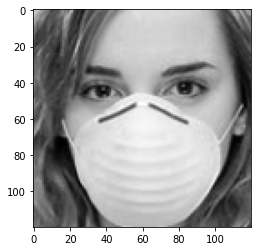

2.jpg


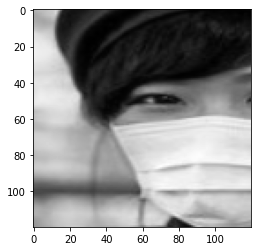

9.jpg


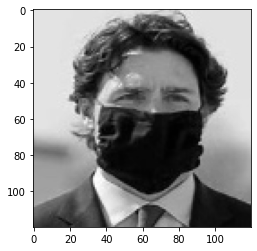

6.jpg


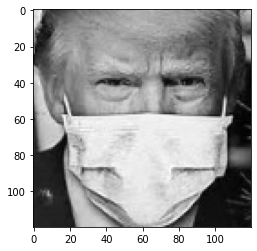

7.jpg


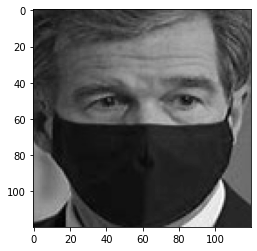

1.jpg


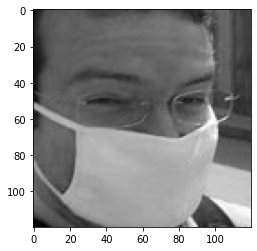

5.jpg


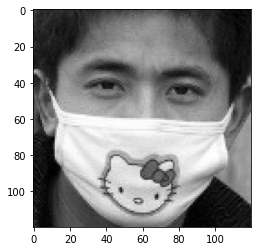

(10, 120, 120)

In [163]:
def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, f'./data/{label}/{path.name}')))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

10.jpg


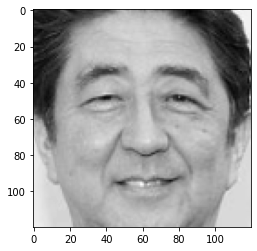

3.jpg


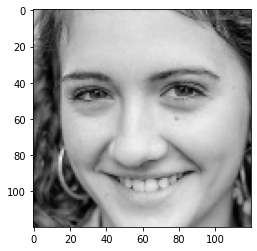

8.jpg


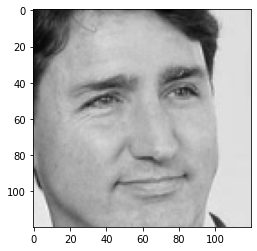

4.jpg


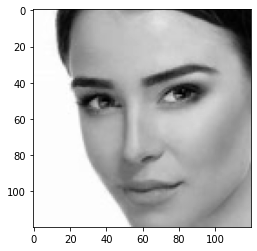

2.jpg


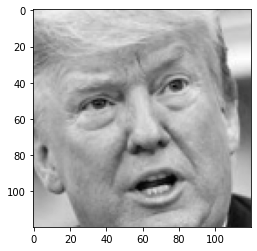

9.jpg


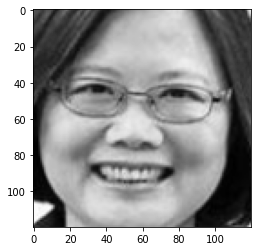

6.jpg


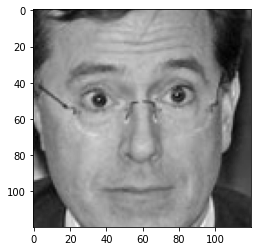

7.jpg


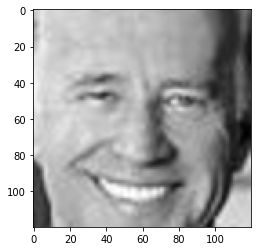

1.jpg


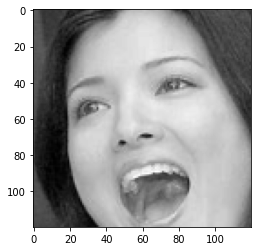

5.jpg


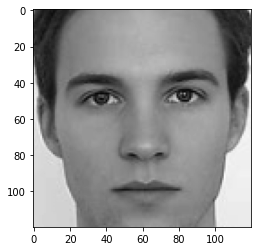

(10, 120, 120)

In [164]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [168]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [172]:
images = np.vstack([images_nomask, images_mask])
images.shape

(20, 120, 120)

In [180]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(20, 14400)

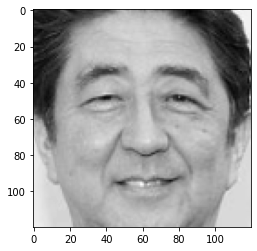

In [181]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [186]:
pca = PCA(n_components=.95)

# tune PCA
pca.fit(X)

pca.explained_variance_ratio_

array([0.24106838, 0.18265854, 0.11500052, 0.10946599, 0.06085532,
       0.05024449, 0.03422517, 0.03007698, 0.02963624, 0.0252859 ,
       0.02017436, 0.01808615, 0.01622557, 0.01464354, 0.01329645])

In [187]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

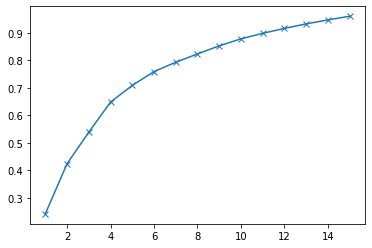

In [188]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [189]:
Z = pca.transform(X)

In [200]:
# let's do a pairplot
df = pd.DataFrame(Z)
df['label'] = labels
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,473.607516,-2729.910972,-1534.331108,-2732.609371,122.009334,998.570673,1270.979143,585.112824,624.400447,-1031.571364,-499.298719,650.679445,242.623119,-468.538911,1594.298900,nomask
1,-1285.685728,639.638796,-2691.830324,201.921767,-1810.224630,-2622.350763,-1062.435501,773.015075,-1056.400755,-463.098251,-266.070506,-1540.781556,1960.320902,862.940284,755.554123,nomask
2,2373.943680,-2305.473491,-1569.769963,-1885.918934,-3304.234256,-746.767631,1840.470784,-433.749754,1775.042083,564.451422,621.710470,-1772.189871,-663.094118,74.799035,-828.445997,nomask
3,4543.934759,-5165.523593,-1001.559531,848.231616,3349.502225,-2644.550718,-47.853481,252.172203,-1561.889010,351.676911,1127.703365,-793.437459,-1145.239666,-755.276468,-254.293591,nomask
4,3287.740693,-287.645192,-2376.092539,880.987292,-789.695056,169.837087,-722.048951,-790.490576,838.849887,2590.795576,-204.765601,1310.295896,-695.642134,2004.872047,847.640000,nomask


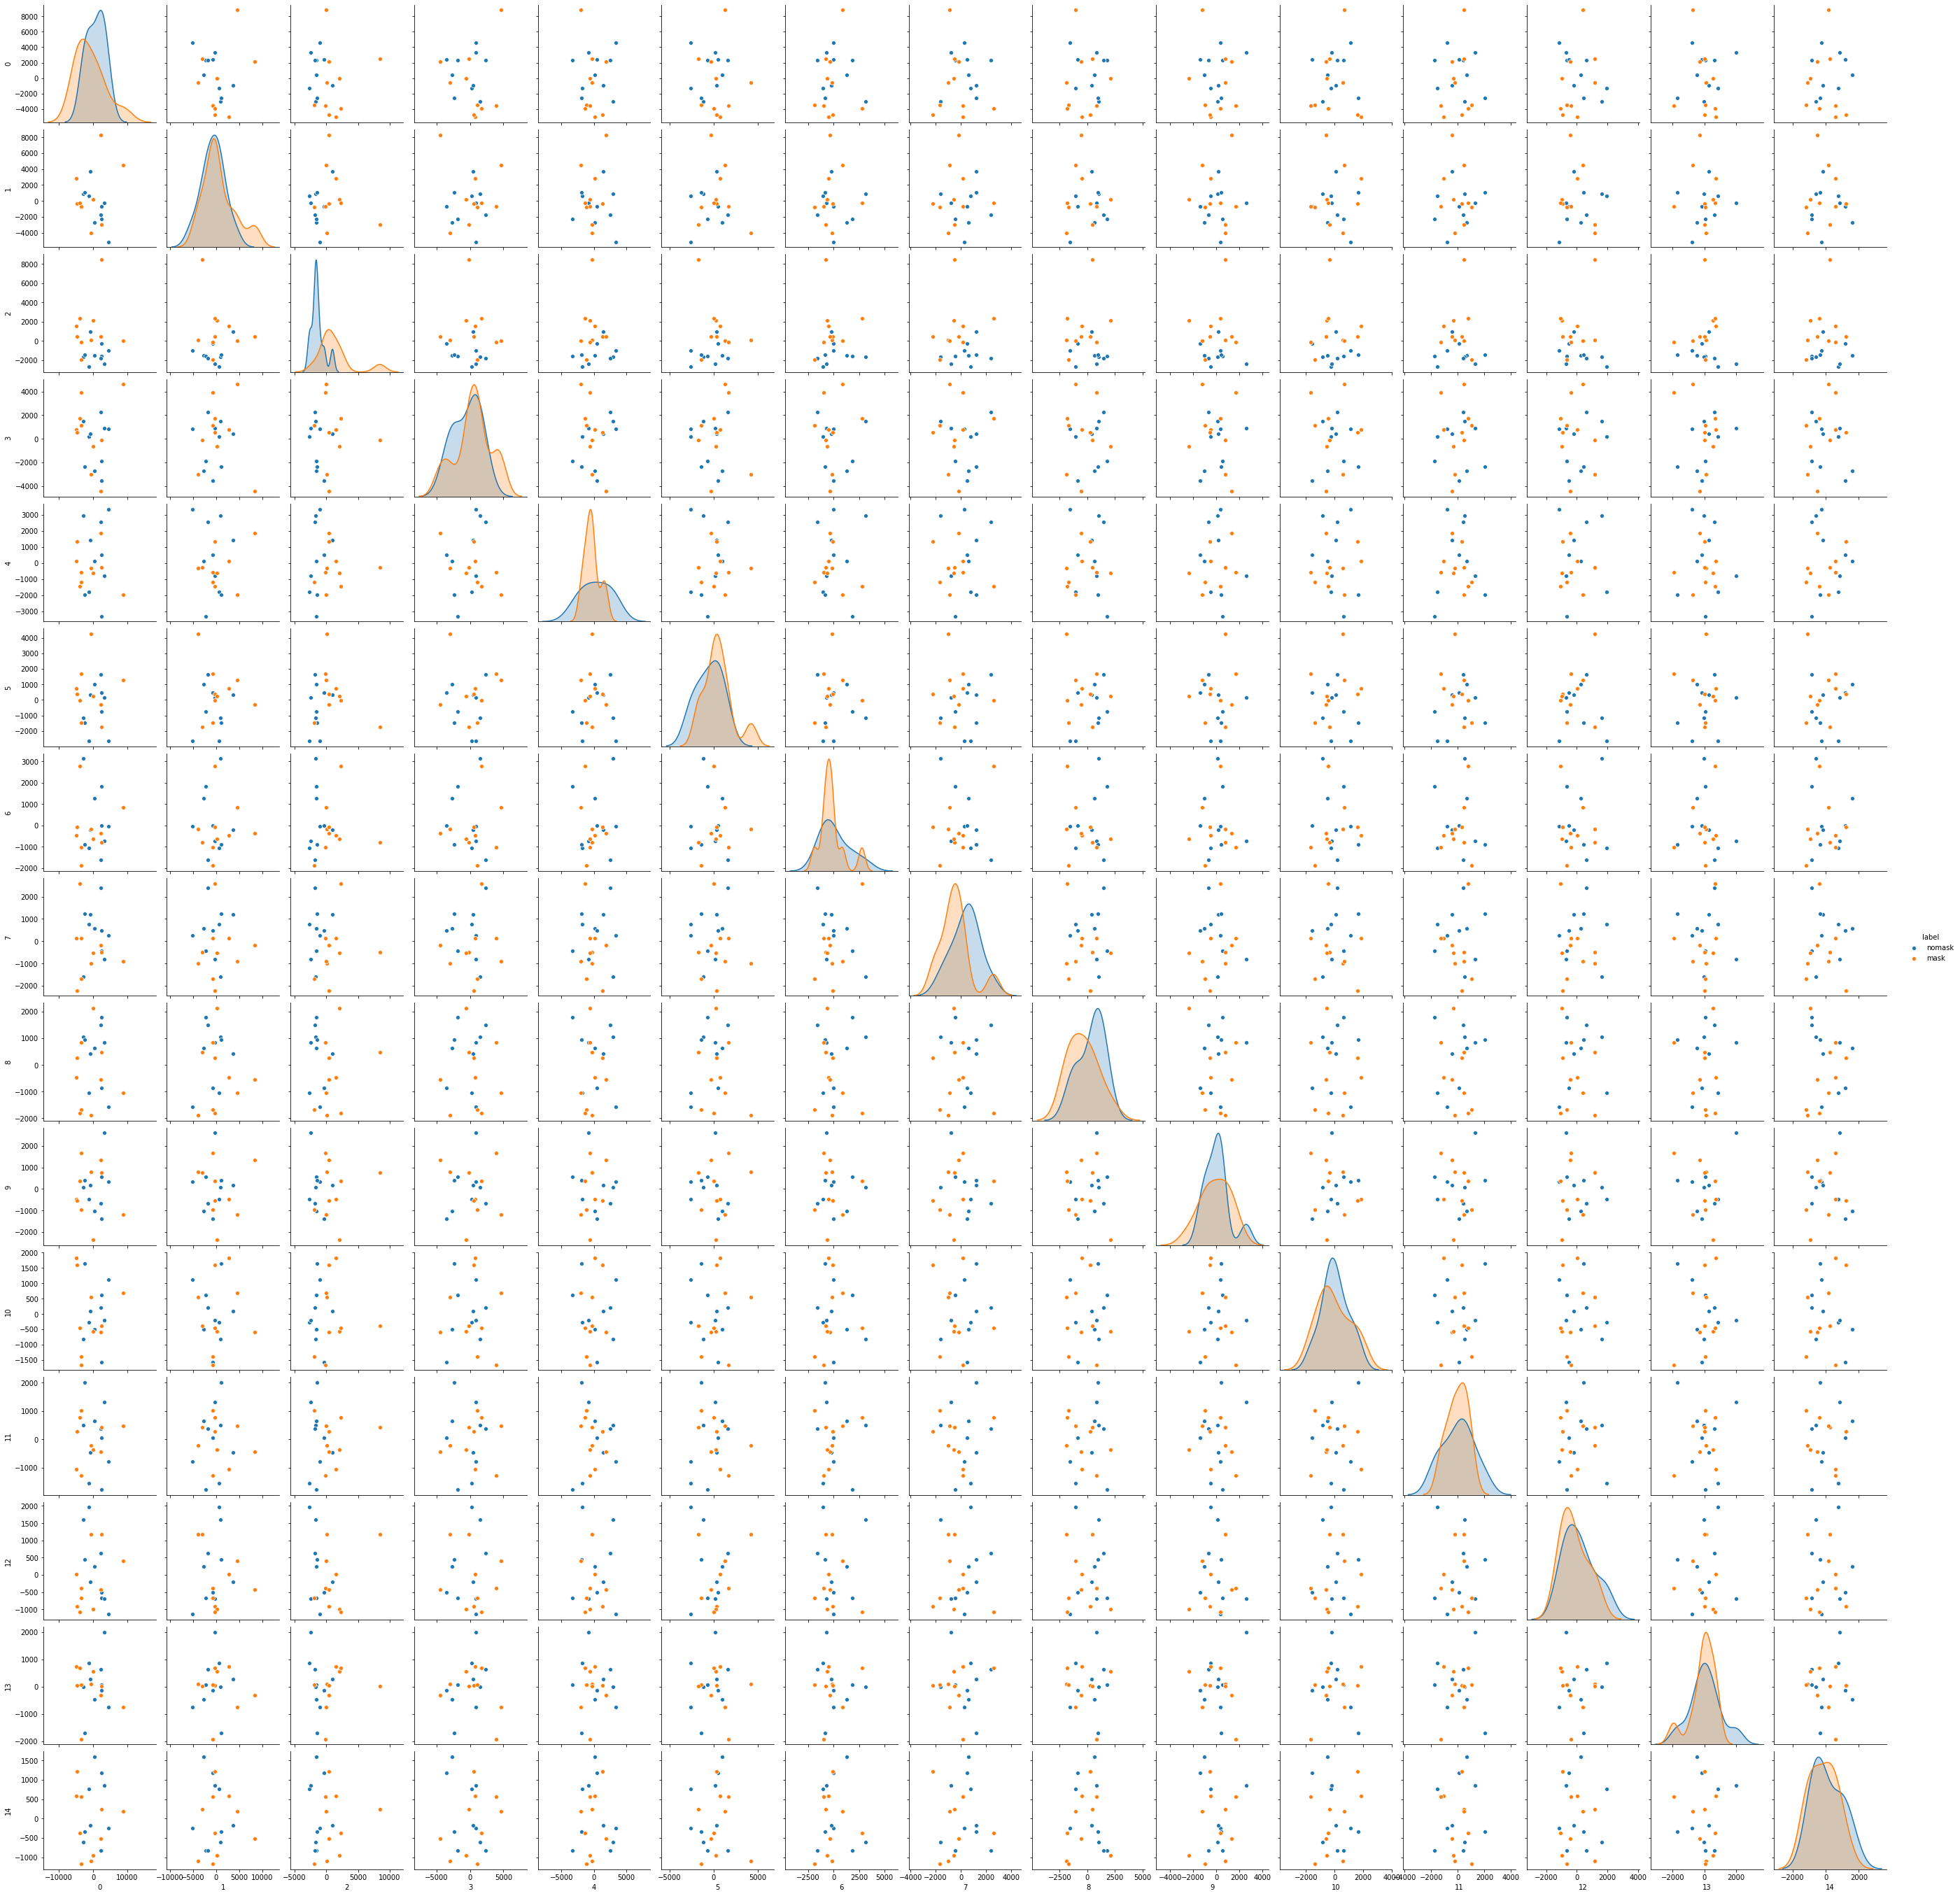

In [201]:
sns.pairplot(df, hue='label')

In [202]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'df' : df,
    'pca' : pca
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))